# Modelos
1. CatBoost
2. XGBoost
3. Random Forest

In [78]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

## Paso 1: Cargar los datos

In [5]:
file_path = 'data/gen/combined_with_clusters.csv'

In [6]:
data = pd.read_csv(file_path)

In [7]:
# Inspeccionar datos
print(data.columns)

Index(['ANO_EMISION', 'MES_EMISION', 'DIA_EMISION', 'REG_MCPIO',
       'QUIEN_REPORTA', 'VIC_SEXO', 'VIC_EDAD', 'TOTAL_HIJOS', 'NUM_HIJ_HOM',
       'NUM_HIJ_MUJ', 'VIC_ALFAB', 'VIC_ESCOLARIDAD', 'VIC_EST_CIV',
       'VIC_GRUPET', 'VIC_NACIONAL', 'VIC_TRABAJA', 'VIC_DEDICA', 'VIC_DISC',
       'VIC_REL_AGR', 'OTRAS_VICTIMAS', 'VIC_OTRAS_HOM', 'VIC_OTRAS_MUJ',
       'VIC_OTRAS_N_OS', 'VIC_OTRAS_N_AS', 'HEC_DIA', 'HEC_MES', 'HEC_ANO',
       'HEC_MCPIO', 'HEC_AREA', 'HEC_TIPAGRE', 'HEC_RECUR_DENUN', 'AGR_SEXO',
       'AGR_EDAD', 'AGR_ALFAB', 'AGR_ESCOLARIDAD', 'AGR_EST_CIV', 'AGR_GRUPET',
       'AGR_NACIONAL', 'AGR_TRABAJA', 'AGR_DEDICA', 'AGRESORES_OTROS_TOTAL',
       'AGR_OTROS_HOM', 'AGR_OTRAS_MUJ', 'AGR_OTROS_N_OS', 'AGR_OTRAS_N_AS',
       'INST_DENUN_HECHO', 'LEY_APLICABLE', 'FECHA_EMISION', 'FECHA_HECHO',
       'REG_DPTO', 'HEC_DPTO', 'MEDIDAS_SEGURIDAD', 'CONTEXTO_DE_VIC',
       'FECHA_ENTRE_EMISION_HECHO', 'HAY_HIJOS', 'HAY_HIJOS_HOM',
       'HAY_HIJOS_MUJ', 'HAY_OTRAS_

In [8]:
data['GAUGE_CLUSTER'].value_counts()

GAUGE_CLUSTER
0    175179
1     89032
2     55567
Name: count, dtype: int64

<Axes: xlabel='GAUGE_CLUSTER'>

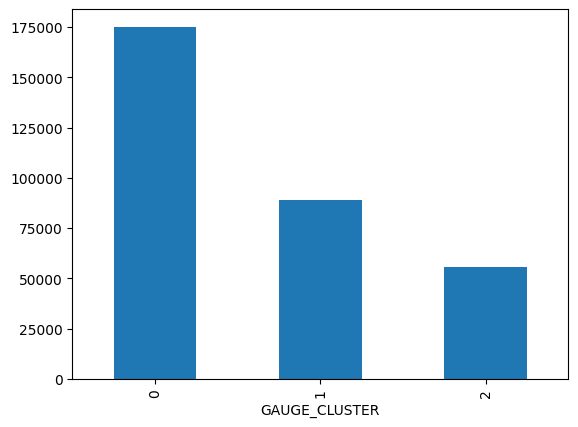

In [9]:
data['GAUGE_CLUSTER'].value_counts().plot(kind='bar')

## Paso 2: Balancear el conjunto

In [10]:
min_samples = data['GAUGE_CLUSTER'].value_counts().min()
min_samples

55567

In [11]:
balanced_data = data.groupby('Gauge Cluster').apply(
    lambda x: x.sample(min_samples)).reset_index(drop=True)

In [12]:
# Verificar que se haya balanceado
balanced_data['GAUGE_CLUSTER'].value_counts()

GAUGE_CLUSTER
0    55567
1    55567
2    55567
Name: count, dtype: int64

## Paso 3: Division de datos de entrenamiento y de prueba

In [57]:
selected_features = ['VIC_EDAD', 'VIC_SEXO', 'VIC_EST_CIV', 'VIC_TRABAJA',
                     'HAY_OTRAS_VIC', 'HEC_DIA', 'HEC_MES', 'HEC_ANO',
                     'AGR_SEXO', 'AGR_EDAD', 'TipoAgre_física', 'TipoAgre_psicológica',
                     'TipoAgre_sexual', 'TipoAgre_patrimonial', 'HAY_HIJOS', 'VIC_ALFAB', 'VIC_GRUPET', 'HEC_RECUR_DENUN']

In [58]:
X = balanced_data[selected_features]

In [59]:
X.head()

,VIC_EDAD,VIC_SEXO,VIC_EST_CIV,VIC_TRABAJA,HAY_OTRAS_VIC,HEC_DIA,HEC_MES,HEC_ANO,AGR_SEXO,AGR_EDAD,TipoAgre_física,TipoAgre_psicológica,TipoAgre_sexual,TipoAgre_patrimonial,HAY_HIJOS,VIC_ALFAB,VIC_GRUPET,HEC_RECUR_DENUN
0,29.0,Mujeres,Casados(as),No,Si,26,2,2021,Hombres,31.0,False,True,False,False,Si,Si,Ladinos(as),No
1,34.0,Mujeres,Casados(as),No,Si,11,2,2018,Hombres,31.0,True,True,False,False,Si,Si,Ladinos(as),No
2,30.0,Mujeres,Casados(as),No,Si,6,11,2021,Mujeres,59.0,False,True,False,False,No,Si,Maya,No
3,41.0,Mujeres,Unidos(as),Si,No,17,3,2020,Mujeres,44.0,False,True,False,False,No,Si,Ladinos(as),No
4,28.0,Mujeres,Unidos(as),No,Si,17,2,2020,Hombres,29.0,True,True,False,False,No,Si,Ladinos(as),No


In [72]:
# Dimensiones de los datos
print(X.shape)

(166701, 18)


### Preprocesando las variables

In [60]:
categorical_features = ['VIC_SEXO', 'VIC_EST_CIV',
                        'VIC_TRABAJA', 'AGR_SEXO', 'HAY_HIJOS', 'HAY_OTRAS_VIC', 'VIC_GRUPET', 'VIC_ALFAB', 'HEC_RECUR_DENUN']
numerical_features = ['VIC_EDAD', 'AGR_EDAD']
binary_features = ['TipoAgre_física',
                   'TipoAgre_psicológica', 'TipoAgre_sexual', 'TipoAgre_patrimonial']
temporal_features = ['HEC_DIA', 'HEC_MES', 'HEC_ANO']

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', OrdinalEncoder(), binary_features),
        ('tem', 'passthrough', temporal_features)
    ])
X_preprocessed = preprocessor.fit_transform(X)

In [65]:
y = balanced_data['GAUGE_CLUSTER']

In [67]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.3, random_state=42, stratify=y)

## Paso 4: Entrenamiento y Evaluación

In [69]:
# Función para evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean CV Score: {scores.mean()}")
    print(f"Std CV Score: {scores.std()}")

### XGBoost

In [70]:
# XGBoost con GridSearchCV
print("Evaluating XGBoost Classifier with GridSearchCV...")

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5,
                        scoring='accuracy', verbose=1)
xgb_grid.fit(X_train, y_train)
print(f"Best parameters: {xgb_grid.best_params_}")
evaluate_model(xgb_grid.best_estimator_, X_train, X_test, y_train, y_test)

Evaluating XGBoost Classifier with GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
[[15710   689   271]
 [ 1443 15227     0]
 [  211     0 16460]]
Accuracy: 0.9477314990702046
Cross-Validation Scores: [0.94699632 0.94656783 0.94721056 0.94746765 0.94896735]
Mean CV Score: 0.947441940183392
Std CV Score: 0.0008177681335562679


### CatBoost

In [73]:
print("Evaluating CatBoost Classifier with GridSearchCV...")

catboost_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

catboost_model = CatBoostClassifier(verbose=0)
catboost_grid = GridSearchCV(
    catboost_model, catboost_params, cv=5, scoring='accuracy', verbose=1)
catboost_grid.fit(X_train, y_train)
print(f"Best parameters: {catboost_grid.best_params_}")
evaluate_model(catboost_grid.best_estimator_, X_train, X_test, y_train, y_test)

Evaluating CatBoost Classifier with GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.2}
[[15688   708   274]
 [ 1433 15237     0]
 [  214     0 16457]]
Accuracy: 0.9474315650556877
Cross-Validation Scores: [0.94682492 0.94712486 0.94789614 0.94703916 0.9489245 ]
Mean CV Score: 0.9475619161881909
Std CV Score: 0.0007714647311630512


### Random Forest

In [79]:
print("Evaluating Random Forest Classifier with GridSearchCV...")

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5,
                       scoring='accuracy', verbose=1)
rf_grid.fit(X_train, y_train)
print(f"Best parameters: {rf_grid.best_params_}")
evaluate_model(rf_grid.best_estimator_, X_train, X_test, y_train, y_test)

Evaluating Random Forest Classifier with GridSearchCV...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\chama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\chama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\chama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
[[15935   399   336]
 [ 1933 14737     0]
 [  171     0 16500]]
Accuracy: 0.9432324888524525
Cross-Validation Scores: [0.94228297 0.94515383 0.94558231 0.94468249 0.94361128]
Mean CV Score: 0.9442625760562173
Std CV Score: 0.001187887338661276


# Guardar los modelos

In [81]:
import pickle


def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

In [83]:
# Save the best XGBoost model
save_model(xgb_grid.best_estimator_, './models/best_xgboost_model.pkl')

# Save the best CatBoost model
save_model(catboost_grid.best_estimator_, './models/best_catboost_model.pkl')

# Save the best Random Forest model
save_model(rf_grid.best_estimator_, './models/best_random_forest_model.pkl')

Model saved to ./models/best_xgboost_model.pkl
Model saved to ./models/best_catboost_model.pkl
Model saved to ./models/best_random_forest_model.pkl


In [ ]:
# def load_model(filename):
#     with open(filename, 'rb') as file:
#         model = pickle.load(file)
#     print(f"Model loaded from {filename}")
#     return model

# loaded_xgb_model = load_model('best_xgboost_model.pkl')
# loaded_catboost_model = load_model('best_catboost_model.pkl')
# loaded_rf_model = load_model('best_random_forest_model.pkl')

# You can now use the loaded models for predictions
# Example:
# y_pred_xgb = loaded_xgb_model.predict(X_test)
# y_pred_catboost = loaded_catboost_model.predict(X_test)
# y_pred_rf = loaded_rf_model.predict(X_test)